In [55]:
import sys
sys.path.append("../ranking/")
sys.path.append("../tests/")

In [136]:
from rank_variants import RankVariants
from measurements_visualizer import MeasurementsVisualizer
from measurements_simulator import MeasurementsSimulator
import pandas as pd
from abc import ABC, abstractmethod

In [195]:
class MeasurementsManager(ABC):
    def __init__(self):
        self.alg_measurements = {}
        super().__init__()
   
    @abstractmethod
    def measure(self, rep_steps, run_id):
        pass
    
    @abstractmethod
    def get_alg_measurements(self):
        pass

In [196]:
class MeasurementsSimulator(MeasurementsManager):
    def __init__(self, config, distribution='normal'):
        super().__init__()
        self.distribution = distribution
        self.config = config
        
    def normal(self, mean, std):
        return np.random.normal(mean, std)
    
    def add_measurement(self, alg, x):
        try:
            self.alg_measurements[alg].append(x)
        except KeyError:
            self.alg_measurements[alg] = []
            self.alg_measurements[alg].append(x)
        
    
    def measure(self, rep_steps, run_id):
        for alg, params in self.config.items():
            for i in range(rep_steps):
                if self.distribution == 'normal':
                    x = self.normal(*params)
                    self.add_measurement(alg,x)
            
    def get_alg_measurements(self):
        return self.alg_measurements


In [197]:
cfg = {}
cfg['alg1']  = [0.2,0.02]
cfg['alg2']  = [0.2,0.01]
cfg['alg3']  = [0.2,0.01]

ms = MeasurementsSimulator(cfg, 'normal')                

In [198]:
ms.measure(3,1)

In [199]:
ms.get_alg_measurements()

{'alg1': [0.17669700318433287, 0.21801652973908375, 0.20931324879460922],
 'alg2': [0.18463756313722776, 0.214882521937956, 0.21895889176030583],
 'alg3': [0.2117877957115965, 0.1982007516418765, 0.18929247378489458]}

In [81]:
h0 = list(cfg.keys())
mv = MeasurementsVisualizer(alg_measurements, h0)

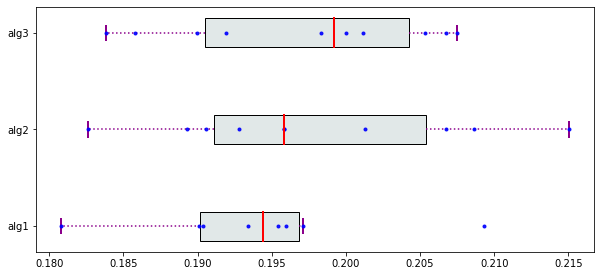

In [82]:
mv.show_measurements_boxplots()

In [92]:
rv = RankVariants(alg_measurements,h0)

In [93]:
ranks, mean_ranks = rv.calculate_mean_rank()

In [95]:
mean_ranks

,case:concept:name,case:mean-rank
0,alg1,0.000
1,alg2,0.125
2,alg3,0.250


In [96]:
ranks

,case:rank:q95-q5,case:rank:q90-q10,case:rank:q85-q15,case:rank:q80-q20,case:rank:q75-q25,case:rank:q70-q30,case:rank:q65-q35,case:rank:q55-q45
case:concept:name,,,,,,,,
alg1,0,0,0,0,0,0,0,0
alg2,0,0,0,0,0,0,0,1
alg3,0,0,0,0,0,0,0,2


In [98]:
data = []
for i, j in enumerate(h0):
    data.append([j, i])
    mean_rank_h0 = pd.DataFrame(data, columns=['case:concept:name', 'case:mean-rank'])

In [128]:
mean_rank_h0

,case:concept:name,case:mean-rank
0,alg1,0
1,alg2,1
2,alg3,2


In [103]:
mean_rank_h0.iloc[:,-1].values

array([0, 1, 2])

In [104]:
np.ones(5)

array([1., 1., 1., 1., 1.])

In [129]:
def measure_and_rank(measurements_manager, h0, rep_steps=3, eps=0.001, max_rep=50):

    initial_ranks = []
    for i, j in enumerate(h0):
        initial_ranks.append([j, i])
    mean_rank_h0 = pd.DataFrame(initial_ranks, columns=['case:concept:name', 'case:mean-rank'])
    mean_rank_log = []
    mean_rank_log.append(mean_rank_h0.set_index('case:concept:name'))

    dy = np.ones(len(h0-1))
    run_id = 0
    norm = 1
    while norm > eps and run_id * rep_steps < max_rep:

        measurements_manager.measure(run_id=run_id,rep_steps=rep_steps)
        alg_measurements = measurements_manager.get_alg_measurements()

        rank_variants = RankVariants(alg_measurements, h0)
        s, mr = rank_variants.calculate_mean_rank()
        
        mean_rank_log.append(mr.set_index('case:concept:name'))
        print(mr)
        df = mean_rank_h0.merge(mr, on=['case:concept:name'])
        x = df.iloc[:,-1].values
        dx = np.convolve(x, [1, -1], 'valid')

        norm = np.linalg.norm(dx - dy, 2) / len(h0)
        print("norm: {}".format(norm))
        
        dy = dx.copy()
        h0 = list(mr.sort_values(by=['case:mean-rank'])['case:concept:name'])

        run_id = run_id + 1

    num_measurements = (run_id) * rep_steps
    print("Number of measurements: {}".format(num_measurements))

    
    return s, mr, pd.concat(mean_rank_log, axis=1)



In [121]:
right

,key,value
0,C,1.867558
1,D,-0.977278
2,A,0.950088
3,B,-0.151357


In [122]:
right.merge(left, on=['key'])

,key,value_x,value_y
0,C,1.867558,0.978738
1,D,-0.977278,2.240893
2,A,0.950088,1.764052
3,B,-0.151357,0.400157


<function abs(x, /)>